In [1]:
import pandas as pd
from opentisim.liquidbulk.hydrogen_defaults import *
from opentisim.liquidbulk.hydrogen_objects import *
import opentisim

# basic inputs
startyear = 2020
lifecycle = 10
years = list(range(startyear, startyear + lifecycle))

# define demand scenario
demand = []
for year in years:
    if year < 2025:
        demand.append(2_000_000)
    else:
        demand.append(4_000_000)
scenario_data = {'year': years, 'volume': demand}

# instantiate a commodity objects
opentisim.liquidbulk.commodity_lhydrogen_data['smallhydrogen_perc'] = 50
opentisim.liquidbulk.commodity_lhydrogen_data['largehydrogen_perc'] = 50

# instantiate a commodity objects
lhydrogen = opentisim.liquidbulk.Commodity(**opentisim.liquidbulk.commodity_lhydrogen_data)
lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

# instantiate vessels
Smallhydrogen = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.smallhydrogen_data)
Largehydrogen = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.largehydrogen_data)
Smallammonia = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.smallammonia_data)
Largeammonia = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.largeammonia_data)
Handysize = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.handysize_data)
Panamax = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.panamax_data)
VLCC = opentisim.liquidbulk.Vessel(**opentisim.liquidbulk.vlcc_data)

vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC]

# define terminal
Terminal = opentisim.liquidbulk.System(
    startyear=startyear,
    lifecycle=1,
    elements=[lhydrogen] + vessels,
    operational_hours=16 * 365,
    terminal_supply_chain={'berth_jetty','pipeline_jetty_-_terminal','storage','h2_retrieval'},
    commodity_type_defaults=opentisim.liquidbulk.commodity_lhydrogen_data,
    storage_type_defaults=opentisim.liquidbulk.storage_lh2_data,
    kendall='E2/E2/n',
    allowable_waiting_service_time_ratio_berth=0.3,
    h2retrieval_type_defaults=opentisim.liquidbulk.h2retrieval_lh2_data, 
    allowable_dwelltime=14 / 365)

Terminal.modelframe = list(range(startyear, startyear + lifecycle))
Terminal.revenues = []
Terminal.demurrage = []
# run simulation
for year in years:
    Terminal.startyear = year
    Terminal.simulate()


In [2]:
print(len(Terminal.elements))
print(len(opentisim.core.find_elements(Terminal, opentisim.liquidbulk.H2retrieval)))
#print(len(opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Jetty)))

years = [2023, 2027]
for index, year in enumerate(years): 
    berths = 0
    jetties = 0 
    #assert the number of jetties online and berths online 
    for element in opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Berth):
        if year >= element.year_online:
            berths += 1 

    for element in opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Jetty):
        if year >= element.year_online:
            jetties += 1 
            
    #assert the berth occupancy and the waiting factor 

    smallhydrogen_calls, largehydrogen_calls,smallammonia_calls, largeammonia_calls, handysize_calls, panamax_calls, vlcc_calls, total_calls, total_vol, smallhydrogen_calls_planned, largehydrogen_calls_planned,                           		smallammonia_calls_planned,largeammonia_calls_planned,handysize_calls_planned, panamax_calls_planned,                   		vlcc_calls_planned, total_calls_planned, total_vol_planned = Terminal.calculate_vessel_calls(year)

    berth_occupancy_planned, berth_occupancy_online, unloading_occupancy_planned, unloading_occupancy_online =              		Terminal.calculate_berth_occupancy(year, smallhydrogen_calls, largehydrogen_calls,                                      		smallammonia_calls,largeammonia_calls, handysize_calls, panamax_calls, vlcc_calls,smallhydrogen_calls_planned,          		largehydrogen_calls_planned, smallammonia_calls_planned,largeammonia_calls_planned, handysize_calls_planned,            		panamax_calls_planned, vlcc_calls_planned)

    WF = opentisim.core.occupancy_to_waitingfactor(utilisation=berth_occupancy_planned, nr_of_servers_to_chk=berths,    		kendall=Terminal.kendall)

    berth_occupancy_online = round(berth_occupancy_online,3)
    WF = round(WF,3)
            
    print('berths', berths, year)
    print('jetties', jetties, year)
    print('berth_occupancy_online', berth_occupancy_online, year)
    print('WF', WF, year)
    
    Jetty_cap_planned = 0
    Jetty_cap = 0

    for commodity in opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Commodity):
        if commodity.type == 'MCH': 
            pump1 = opentisim.liquidbulk.handysize_data["pump_capacity"]
            pump2 = opentisim.liquidbulk.panamax_data["pump_capacity"]
            pump3 = opentisim.liquidbulk.vlcc_data["pump_capacity"]
            pumpall = np.array([pump1, pump2, pump3])
            pumpall = pumpall[np.nonzero(pumpall)]
        elif commodity.type == 'Liquid hydrogen':
            pump1 = opentisim.liquidbulk.smallhydrogen_data["pump_capacity"]
            pump2 = opentisim.liquidbulk.largehydrogen_data["pump_capacity"]
            pump3 = 0
            pumpall = np.array([pump1, pump2, pump3])
            pumpall = pumpall[np.nonzero(pumpall)]
        else:
            pump1 = sopentisim.liquidbulk.mallammonia_data["pump_capacity"] 
            pump2 = opentisim.liquidbulk.largeammonia_data["pump_capacity"]
            pump3 = 0
            pumpall = np.array([pump1, pump2, pump33])
            pumpall = pumpall[np.nonzero(pumpall)]

    for element in opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Jetty):
        Jetty_cap_planned += (sum(pumpall) / len(pumpall) * Terminal.operational_hours)
        if year >= element.year_online:
            Jetty_cap += (sum(pumpall) / len(pumpall) * Terminal.operational_hours)
    Jetty_cap = round(Jetty_cap) 
    print('jetty cap', Jetty_cap, year)
    
    Demand = []
    Commodity = opentisim.liquidbulk.Commodity(**opentisim.liquidbulk.commodity_lhydrogen_data)
    for commodity in opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Commodity):
        try:
            Demand = commodity.scenario_data.loc[commodity.scenario_data['year'] == year]['volume'].item()
        except:
        #print('problem occurs at {}'.format(year))
            pass

    throughput_online, throughput_terminal_in ,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in= Terminal.throughput_elements(year)


    #throughput_online, throughput_planned, throughput_planned_jetty, throughput_planned_pipej, throughput_planned_storage,  		throughput_planned_h2retrieval, throughput_planned_pipeh = Terminal.throughput_elements(year)

    print('demand', Demand, year)
    print('throughput_online', throughput_online, year)
    
    # Find pipeline jetty capacity
    pipelineJ_capacity_planned = 0
    pipelineJ_capacity_online = 0
    list_of_elements = opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Pipeline_Jetty)
    if list_of_elements != []:
        for element in list_of_elements:
            pipelineJ_capacity_planned += (sum(pumpall) / len(pumpall) * Terminal.operational_hours) #element.capacity *    				self.operational_hours
            if year >= element.year_online:
                pipelineJ_capacity_online += (sum(pumpall) / len(pumpall) * Terminal.operational_hours)#element.capa
    pipelineJ_capacity_online = round(pipelineJ_capacity_online)   

    Demand = []
    Commodity = opentisim.liquidbulk.Commodity(**opentisim.liquidbulk.commodity_lhydrogen_data)
    for commodity in opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Commodity):
        try:
            Demand = commodity.scenario_data.loc[commodity.scenario_data['year'] == year]['volume'].item()
        except:
        #print('problem occurs at {}'.format(year))
            pass


    # Find plant capacity
    h2retrieval_capacity_planned = 0
    h2retrieval_capacity_online = 0
    list_of_elements = opentisim.core.find_elements(Terminal, opentisim.liquidbulk.H2retrieval)
    if list_of_elements != []:
        for element in list_of_elements:
            h2retrieval_capacity_planned += element.capacity * Terminal.operational_hours
            if year >= element.year_online:
                h2retrieval_capacity_online += element.capacity * Terminal.operational_hours


    h2retrieval_capacity_planned = round(h2retrieval_capacity_planned)
    h2retrieval_capacity_online = round(h2retrieval_capacity_online)

    plant_occupancy_planned, plant_occupancy_online, h2retrieval_capacity_planned, h2retrieval_capacity_online= Terminal.calculate_h2retrieval_occupancy( year, opentisim.liquidbulk.h2retrieval_lh2_data) 
    plant_occupancy_online = round(plant_occupancy_online,2)

        # Find storage capacity
    storage_capacity_planned = 0
    storage_capacity_online = 0
    list_of_elements = opentisim.core.find_elements(Terminal, opentisim.liquidbulk.Storage)
    if list_of_elements != []:
        for element in list_of_elements:
            storage_capacity_planned += element.capacity
            if year >= element.year_online:
                storage_capacity_online += element.capacity

    storage_cap_planned = storage_capacity_planned / Terminal.allowable_dwelltime / 1.1
    storage_cap_planned = round(storage_cap_planned)
    storage_cap_online = storage_capacity_online / Terminal.allowable_dwelltime / 1.1
    storage_cap_online = round(storage_cap_online )
    
    print('pipelineJ_capacity_online ', pipelineJ_capacity_online, year)
    print('h2retrieval_capacity_online', h2retrieval_capacity_online, year)
    print('plant_occupancy_online', plant_occupancy_online, year)
    print('storage_cap_online', storage_cap_online, year)

67
5
berths 1 2023
jetties 1 2023
berth_occupancy_online 0.338 2023
WF 0.047 2023
jetty cap 8535452.0 2023
demand 2000000 2023
throughput_online 2000000 2023
pipelineJ_capacity_online  8535452.0 2023
h2retrieval_capacity_online 2400240 2023
plant_occupancy_online 0.83 2023
storage_cap_online 2019351 2023
berths 2 2027
jetties 2 2027
berth_occupancy_online 0.336 2027
WF 0.036 2027
jetty cap 17070904.0 2027
demand 4000000 2027
throughput_online 4000000 2027
pipelineJ_capacity_online  17070904.0 2027
h2retrieval_capacity_online 4000400 2027
plant_occupancy_online 1.0 2027
storage_cap_online 4038701 2027


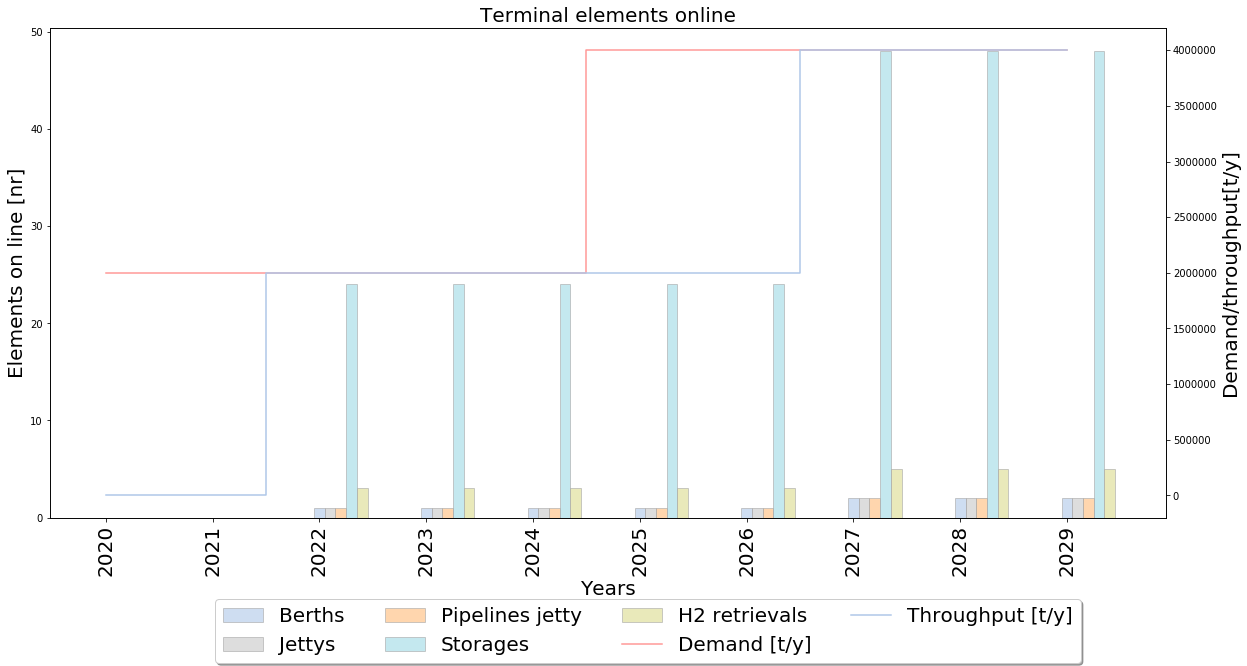

In [3]:


Terminal.terminal_elements_plot()
#plt.savefig('BerthJettyPipePlant.png', bbox_inches = 'tight',dpi=300)

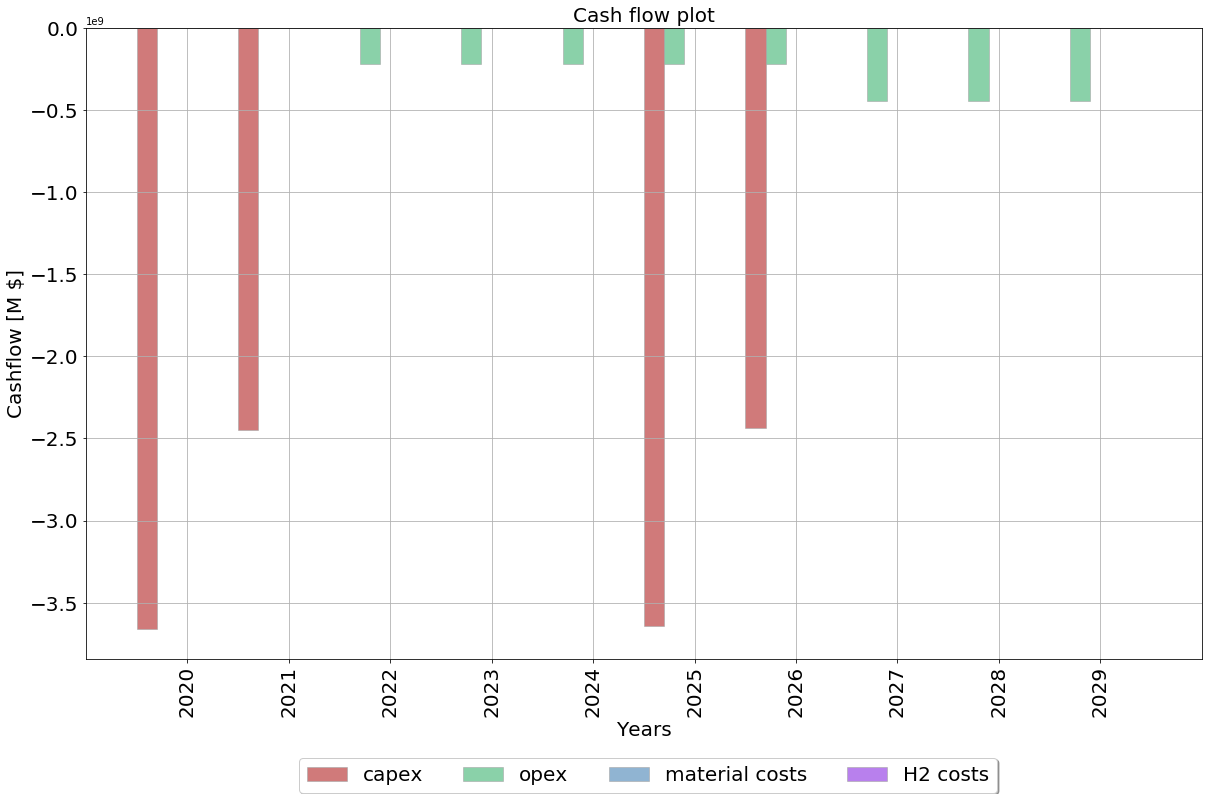

In [4]:
labour = opentisim.liquidbulk.Labour(**opentisim.liquidbulk.labour_data)
cash_flows, cash_flows_WACC_real = opentisim.core.add_cashflow_elements(Terminal, labour)
#print(cash_flows)
opentisim.plot.cashflow_plot(Terminal, cash_flows)

In [8]:
for element in Terminal.elements:
        if hasattr(element, 'purchaseH2'):
            print(element)
#             element.df = element.df.fillna(0)
#             for column in cash_flows.columns:
#                 if column in element.df.columns and column != "year":
#                     cash_flows[column] += element.df[column]